In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Sequence, List, Literal, Annotated, cast
from pydantic import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_groq.chat_models import ChatGroq
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults

from  langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState, BaseMessage
from langgraph.prebuilt import tools_condition, ToolNode

In [2]:
groq_api_key = os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")
llm.invoke("hi").content

'Hi there! 👋 What can I do for you today?\n'

In [3]:
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [4]:
file_path = r"E:\2025\Generative_AI\LangGraph\LangGraph_E2E\data\Gujrat_accident.pdf"

docs = PyPDFLoader(file_path).load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = text_splitter.split_documents(docs)

vectordb = Chroma.from_documents(documents=documents,
                                 collection_name="rag",
                                 embedding=embeddings)

retriever = vectordb.as_retriever()

In [5]:
retriever.get_relevant_documents("main cause of air crash?")

C:\Users\sowmy\AppData\Local\Temp\ipykernel_29460\3813989304.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("main cause of air crash?")


[Document(metadata={'source': 'E:\\2025\\Generative_AI\\LangGraph\\LangGraph_E2E\\data\\Gujrat_accident.pdf', 'page_label': '2', 'producer': 'xdvipdfmx (20220710)', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-06-17T17:22:18+00:00', 'total_pages': 3, 'page': 1}, page_content='cient thrust. Unverified claims on X mention fuel contamination, but no\nevidence supports this. Weather was clear (visibility 6 km, light winds 3–6\nknots), ruling out meteorological factors.\n• Investigating Bodies: Aircraft Accident Investigation Bureau (AAIB) India,\nDGCA, US NTSB, FAA, UK AAIB, and a high-level committee led by Union\nHome Secretary Govind Mohan. Final report expected by June 2026.\nFigure 3: Recovered black box of Flight AI171, critical for determining the cause\nof the crash.'),
 Document(metadata={'creationdate': '2025-06-17T17:22:18+00:00', 'producer': 'xdvipdfmx (20220710)', 'total_pages': 3, 'page': 2, 'creator': 'LaTeX with hyperref', 'page_label': '3', 'source': 'E:\\2025\\

In [6]:
class Analyser(BaseModel):
    Topic: str = Field(description="Select the related topic based on question. 'Retriever call', 'LLM call', 'Internet call'")
    Reason: str = Field(description="Reason for topic selection")

In [7]:
def supervisor(state: MessagesState):
    print("-- SUPERVISOR ---")
    question = state['messages']
    
    llm_with_structured = llm.with_structured_output(Analyser)
    
    template = """You are an analyser to identify the below specific topic based on the user question {question}.
    The topics are:
    1. Retriever call: If the question is related to Ahamadabad air crash
    2. LLM call: If the question is related to old news
    3. Internet call: If the question is related to current news
    Note: Provide only these topics 'Retriever call', 'LLM call', 'Internet call'
    """  
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"]
    )
    
    chain = cast(Analyser, prompt | llm_with_structured)
    response = chain.invoke(question)
    print(response)
    
    return {"messages": [response.Topic]}
    

In [8]:
response = supervisor({"messages": ["cause for the air crash"]})
response

-- SUPERVISOR ---
Topic='LLM call' Reason='Cause of air crash'


{'messages': ['LLM call']}

In [9]:
def router(state: MessagesState):
    print("--- ROUTER ---")
    last_message = state['messages'][-1].content
    
    if "Retriever call" in last_message:
        return "RAG"
    elif "LLM call" in last_message:
        return "LLM"
    elif "Internet call" in last_message:
        return "Internet"
    else:
        return "None"

In [10]:
class AnswerParser(BaseModel):
    answer: str = Field(description="Answer to the given question")

In [11]:
# def tool_call(state: MessagesState):
#     print("--- TOOL CALL ---")
#     question = state['messages'][0].content
#     print(question)
    
#     tavily_tool = TavilySearchResults()
    
#     result = tavily_tool.invoke(question)
    
#     parser = PydanticOutputParser(pydantic_object=AnswerParser)
#     llm_with_strcture_ans_op = llm.with_structured_output(AnswerParser)
    
#     prompt = PromptTemplate(
#         template="You are an ai assistant provide the consise answer based on the provided context {context}\nQuestion{question}\n{format_instructions}",
#         input_variables=["context", "question"],
#         partial_variables={"format_instructions": parser.get_format_instructions()}
#     )
    
#     chain = prompt | llm | parser
    
#     response = chain.invoke({"context": result, "question": question})
#     print(response.answer)
    
#     return {"messages": [response.answer]}

In [12]:
def tool_call(state: MessagesState):
    print("--- TOOL CALL ---")
    question = state['messages'][0].content
    print(question)
    
    tavily_tool = TavilySearchResults()
    
    result = tavily_tool.invoke(question)
    
    prompt = PromptTemplate(
        template="You are an ai assistant provide the consise answer based on the provided context {context}\nQuestion{question}",
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"context": result, "question": question})
    
    return {"messages": [response]}

In [13]:
# tool_call({"messages": ["cause for the air crash"]})

In [14]:
def validator(state: MessagesState):
    print("---VALIDATOR---")
    question = state['messages'][0].content
    last_message = state['messages'][-1].content
    
    parser = PydanticOutputParser(pydantic_object=AnswerParser)
    
    prompt = PromptTemplate(
        template="""
    You are an intelligent assistant. You MUST reply ONLY in the following JSON format and nothing else.

    {format_instructions}

    Answer this question based on the context:
    Context: {context}
    Question: {question}
    """,
        input_variables=["context", "question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm | parser
    
    response = chain.invoke({"context": last_message, "question": question})
    
    
    print("-----------")
    print(response)
    
    # return {"messages": [{"role": "assistant", "content": response.dict()}]}

    return {
        "messages": [
            {
                "role": "assistant",
                "content": response.answer
            }
        ]
    }

In [15]:
# validator({"messages": ["cause for air crash"]})

In [16]:
workflow = StateGraph(MessagesState)

workflow.add_node("Supervisor", supervisor)
workflow.add_node("Tool_CALL", tool_call)
workflow.add_node("Validator", validator)

workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG": "Tool_CALL",
        "LLM": "Tool_CALL",
        "Internet": "Tool_CALL"
    }
)

workflow.add_edge("Tool_CALL", "Validator")
workflow.add_edge("Validator", END)

# workflow.add_edge("Tool_CALL", END)



app = workflow.compile()

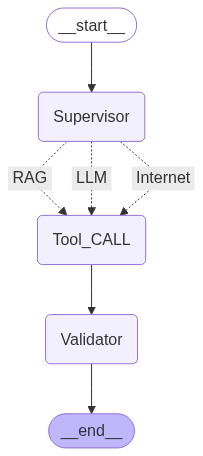

In [17]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
app.invoke({"messages": ["cause for the air crash"]})

-- SUPERVISOR ---
Topic='Retriever call' Reason='Identifying the topic based on user question'
--- ROUTER ---
--- TOOL CALL ---
cause for the air crash
---VALIDATOR---
-----------
answer='Possible causes for air crashes include pilot error, engine failure, system errors, weather, and other human error.'


{'messages': [HumanMessage(content='cause for the air crash', additional_kwargs={}, response_metadata={}, id='24ba4c69-b198-4f83-a761-aa307428037e'),
  HumanMessage(content='Retriever call', additional_kwargs={}, response_metadata={}, id='ccd0ee9b-cf58-4346-b488-13f7cc5c1f28'),
  HumanMessage(content="Based on the provided context, possible causes for air crashes include:\n\n* **Pilot error:** This can encompass various factors like inadequate preflight preparation, failure to maintain proper speed or altitude, misjudgment of fuel, and improper handling of controls.\n* **Engine failure:** Mechanical issues with the engine can lead to loss of power and control, causing a rapid descent.\n* **System errors:** Malfunctions in the aircraft's control systems can prevent pilots from effectively controlling the plane.\n* **Weather:** Adverse weather conditions can significantly impact flight safety and contribute to accidents.\n* **Other human error:** This can include air traffic controller m

In [19]:
for events in app.stream({"messages": ["cause for the air crash"]}):
    for key, value in events.items():
        print("Node name: {key}")
        print(value)
        print("----")

-- SUPERVISOR ---
Topic='Retriever call' Reason='Identifying the cause of an air crash'
--- ROUTER ---
Node name: {key}
{'messages': ['Retriever call']}
----
--- TOOL CALL ---
cause for the air crash
Node name: {key}
{'messages': ['The provided context lists several common causes of air crashes:\n\n* **Pilot error:** This can include inadequate preparation, failure to maintain speed or direction, improper level off, and mismanaging fuel. \n* **Engine failure:** This can lead to a loss of control and altitude.\n* **System errors:** Malfunctions in aircraft controls can prevent pilots from controlling the aircraft properly.\n* **Weather:**  Not mentioned in the context, but weather is a significant factor in many air crashes.\n* **Other human error:** This includes air traffic controller errors, improper loading of aircraft, and maintenance issues. \n\n\nThe specific cause of the air crash in the BBC article is still under investigation. \n\n\nLet me know if you have a specific crash in 